# tables 
# normal

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
sys.path.append("..")
from modules.utils import paper_style
from sklearn.metrics import r2_score
from helper_fn import *
sys.path.append("..")
current_dir = ""
relative_path = "../data"
path = os.path.join(current_dir, relative_path)
data_path = os.path.join(path, "test/")
data_drug_path = os.path.join(path, "test_drug/")
gt_path = os.path.join(path, "GT/")
gt_drug_path = os.path.join(path, "GT_drug/labels/")

drug = False

if drug:
    data_path_ = data_drug_path
    gt_path_ = gt_drug_path
else:
    data_path_ = data_path
    gt_path_ = gt_path

gt_tracks = []
taus = []
for i, fn in enumerate(os.listdir(gt_path_)):
    track = np.load(os.path.join(gt_path_, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks.append(track)
    taus.append(tau)
track_lengths = [track.shape[0] for track in gt_tracks]
modalities = ["bf", "h2b"]
data = {}
for mod in modalities:
    data[mod] = {}
    for head in heads:
        # loading the dataset
        tracks = get_data(data_path_, mod, head)
        data[mod][head] = tracks

good_heads = ["mlp", "cnn", "lstm", "xtransformer-causal", "mamba", "xtransformer"]
data['bf']['GT'] = gt_tracks
data['h2b']['GT'] = gt_tracks

In [32]:

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from dtaidistance import dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import itertools

columns = ['$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$R^2_{FUCCI_1}$', '$R^2_{FUCCI_2}$', '$L_1$', '$R^2$', '$DTW$', ]
super_columns = {'bf':"Brightfield", 'h2b': "Histone H2B"}
good_heads = ["mlp", "cnn", "lstm", "xtransformer-causal", "mamba", "xtransformer"]
models = {key:val for key, val in zip(good_heads, ['Single Frame', 'Causal CNN', 'LSTM', 'Causal Transformer', 'Mamba', 'Transformer'])}
rows = []
dtw_vals = pd.read_csv('df_metrics.csv')
dtw_std_vals = pd.read_csv('df_metrics_std.csv')
for mod in ['bf', 'h2b']:
    for head in good_heads:
        print(mod, head)
        l1_red_vals = [mean_absolute_error(data[mod][head][idx][:, 1], data[mod]['GT'][idx][:, 1]) for idx in range(len(gt_tracks))]
        l1_green_vals = [mean_absolute_error(data[mod][head][idx][:, 0], data[mod]['GT'][idx][:, 0]) for idx in range(len(gt_tracks))]
        r2_red_vals = [r2_score(gt_tracks[idx][:, 1], data[mod][head][idx][:, 1]) for idx in range(len(gt_tracks))]
        r2_green_vals = [r2_score(gt_tracks[idx][:, 0], data[mod][head][idx][:, 0]) for idx in range(len(gt_tracks))]
        l1_vals = [mean_absolute_error(data[mod][head][idx], data[mod]['GT'][idx]) for idx in range(len(gt_tracks))]
        r2_vals = [r2_score(gt_tracks[idx], data[mod][head][idx]) for idx in range(len(gt_tracks))]
        
        dtw_mean, dtw_std = dtw_vals[(dtw_vals['head'] == models[head]) & (dtw_vals['modality'] == mod)]['DTW'].values[0], dtw_std_vals[(dtw_std_vals['head'] == models[head]) & (dtw_std_vals['modality'] == mod)]['DTW_std'].values[0]
        rows.append([
            [np.mean(l1_red_vals), np.std(l1_red_vals)],
            [np.mean(l1_green_vals), np.std(l1_green_vals)],
            [np.mean(r2_red_vals), np.std(r2_red_vals)],
            [np.mean(r2_green_vals), np.std(r2_green_vals)],
            [np.mean(l1_vals), np.std(l1_vals)],
            [np.mean(r2_vals), np.std(r2_vals)],
            [dtw_mean, dtw_std]
        ])

rows_mean = [list(zip(*r))[0] for r in rows]
rows_std = [list(zip(*r))[1] for r in rows]

data_ = pd.concat([pd.DataFrame(rows_mean[:len(rows_mean)//2]), pd.DataFrame(rows_mean[len(rows_mean)//2:])], axis=1)
data_.columns = pd.MultiIndex.from_product([list(super_columns.values()), columns])
data_.index = list(models.values())

std_values = pd.concat([pd.DataFrame(rows_std[:len(rows_std)//2]), pd.DataFrame(rows_std[len(rows_std)//2:])], axis=1)
std_values.columns = pd.MultiIndex.from_product([list(super_columns.values()), columns])
std_values.index = list(models.values())

latex_df = data_.copy()
skip_std = False
for col in itertools.product(list(super_columns.values()), ['$L_1$', '$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$DTW$']):
    min_value = data_[col].min()
    min_std = std_values[col][data_[col] == min_value]
    latex_df[col] = data_[col].apply(lambda x: f"\\textbf{{{x:.3f}}}" if x == min_value else f"{x:.3f}")
    if not skip_std:
        latex_df[col] += std_values[col].apply(
            lambda s: f" \\textbf{{± {s:.3f}}}" if s in min_std.values else f" ± {s:.3f}"
        )

for col in itertools.product(list(super_columns.values()), ['$R^2_{FUCCI_1}$', '$R^2_{FUCCI_2}$', '$R^2$']):
    max_value = data_[col].max()
    max_std = std_values[col][data_[col] == max_value]
    latex_df[col] = data_[col].apply(lambda x: f"\\textbf{{{x:.3f}}}" if x == max_value else f"{x:.3f}")
    if not skip_std:
        latex_df[col] += std_values[col].apply(
            lambda s: f" \\textbf{{± {s:.3f}}}" if s in max_std.values else f" ± {s:.3f}"
        )

display(latex_df)
with open("table1.tex", "w") as f:
    f.write(latex_df.to_latex(index=True, escape=False))


bf mlp
bf cnn
bf lstm
bf xtransformer-causal
bf mamba
bf xtransformer
h2b mlp
h2b cnn
h2b lstm
h2b xtransformer-causal
h2b mamba
h2b xtransformer


Brightfield  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.239 ± 0.082   
Causal CNN                            0.252 ± 0.113   
LSTM                                  0.424 ± 0.101   
Causal Transformer                    0.326 ± 0.104   
Mamba                                 0.485 ± 0.090   
Transformer         \textbf{0.147} \textbf{± 0.056}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.182 ± 0.056   
Causal CNN                            0.161 ± 0.059   
LSTM                                  0.229 ± 0.045   
Causal Transformer                    0.214 ± 0.049   
Mamba                                 0.259 ± 0.045   
Transformer         \textbf{0.139} \textbf{± 0.048}   

                                                     \
                                    $R^2_{FUCCI_1}$   
Single Frame                         -0.911 ± 1.877   
Causal CNN                           -1.131 ± 2.627   
LSTM                                 -3.269 ± 3.211   
Causal Transformer                   -1.566 ± 2.859   
Mamba                                -4.175 ± 3.623   
Transformer         \textbf{0.196} \textbf{± 0.823}   

                                                     \
                                    $R^2_{FUCCI_2}$   
Single Frame                          0.317 ± 0.370   
Causal CNN                            0.425 ± 0.388   
LSTM                                 -0.057 ± 0.344   
Causal Transformer                    0.110 ± 0.351   
Mamba                                -0.313 ± 0.401   
Transformer         \textbf{0.619} \textbf{± 0.248}   

                                                     \
                                              $L_1$   
Single Frame                          0.210 ± 0.061   
Causal CNN                            0.206 ± 0.080   
LSTM                                  0.326 ± 0.066   
Causal Transformer                    0.270 ± 0.070   
Mamba                                 0.372 ± 0.061   
Transformer         \textbf{0.143} \textbf{± 0.041}   

                                                     \
                                              $R^2$   
Single Frame                         -0.297 ± 1.064   
Causal CNN                           -0.353 ± 1.459   
LSTM                                 -1.663 ± 1.727   
Causal Transformer                   -0.728 ± 1.558   
Mamba                                -2.244 ± 1.949   
Transformer         \textbf{0.408} \textbf{± 0.478}   

                                                     \
                                              $DTW$   
Single Frame                          5.329 ± 1.147   
Causal CNN                            4.323 ± 1.302   
LSTM                                  3.685 ± 1.678   
Causal Transformer                    5.159 ± 1.562   
Mamba                                 3.563 ± 1.918   
Transformer         \textbf{3.022} \textbf{± 0.985}   

                                        Histone H2B  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.183 ± 0.050   
Causal CNN                            0.149 ± 0.042   
LSTM                                  0.140 ± 0.051   
Causal Transformer                    0.132 ± 0.034   
Mamba                                 0.185 ± 0.078   
Transformer         \textbf{0.074} \textbf{± 0.029}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.107 ± 0.048   
Causal CNN                            0.125 ± 0.040   
LSTM                                  0.115 ± 0.040   
Causal Transformer                    0.111 ± 0.037   
Mamba                                 0.134 ± 0.043   
Transformer         \textbf{0.095} \textbf{± 0.031}   

                                                     \
                

In [34]:
sel_metrics = ['$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$R^2_{FUCCI_1}$', '$R^2_{FUCCI_2}$', '$DTW$', ]
new_columns = pd.MultiIndex.from_product([list(super_columns.values()), sel_metrics])
latex_df_sel = latex_df[new_columns]
display(latex_df_sel)
with open("table1_selected_plusminus.tex", "w") as f:
    f.write(latex_df_sel.to_latex(index=True, escape=False))

Brightfield  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.239 ± 0.082   
Causal CNN                            0.252 ± 0.113   
LSTM                                  0.424 ± 0.101   
Causal Transformer                    0.326 ± 0.104   
Mamba                                 0.485 ± 0.090   
Transformer         \textbf{0.147} \textbf{± 0.056}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.182 ± 0.056   
Causal CNN                            0.161 ± 0.059   
LSTM                                  0.229 ± 0.045   
Causal Transformer                    0.214 ± 0.049   
Mamba                                 0.259 ± 0.045   
Transformer         \textbf{0.139} \textbf{± 0.048}   

                                                     \
                                    $R^2_{FUCCI_1}$   
Single Frame                         -0.911 ± 1.877   
Causal CNN                           -1.131 ± 2.627   
LSTM                                 -3.269 ± 3.211   
Causal Transformer                   -1.566 ± 2.859   
Mamba                                -4.175 ± 3.623   
Transformer         \textbf{0.196} \textbf{± 0.823}   

                                                     \
                                    $R^2_{FUCCI_2}$   
Single Frame                          0.317 ± 0.370   
Causal CNN                            0.425 ± 0.388   
LSTM                                 -0.057 ± 0.344   
Causal Transformer                    0.110 ± 0.351   
Mamba                                -0.313 ± 0.401   
Transformer         \textbf{0.619} \textbf{± 0.248}   

                                                     \
                                              $DTW$   
Single Frame                          5.329 ± 1.147   
Causal CNN                            4.323 ± 1.302   
LSTM                                  3.685 ± 1.678   
Causal Transformer                    5.159 ± 1.562   
Mamba                                 3.563 ± 1.918   
Transformer         \textbf{3.022} \textbf{± 0.985}   

                                        Histone H2B  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.183 ± 0.050   
Causal CNN                            0.149 ± 0.042   
LSTM                                  0.140 ± 0.051   
Causal Transformer                    0.132 ± 0.034   
Mamba                                 0.185 ± 0.078   
Transformer         \textbf{0.074} \textbf{± 0.029}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.107 ± 0.048   
Causal CNN                            0.125 ± 0.040   
LSTM                                  0.115 ± 0.040   
Causal Transformer                    0.111 ± 0.037   
Mamba                                 0.134 ± 0.043   
Transformer         \textbf{0.095} \textbf{± 0.031}   

                                                     \
                                    $R^2_{FUCCI_1}$   
Single Frame                         -0.229 ± 0.842   
Causal CNN                            0.103 ± 0.684   
LSTM                                  0.279 ± 0.741   
Causal Transformer                    0.513 ± 0.381   
Mamba                                -0.116 ± 1.190   
Transformer         \textbf{0.756} \textbf{± 0.206}   

                                                     \
                                    $R^2_{FUCCI_2}$   
Single Frame                          0.748 ± 0.218   
Causal CNN                            0.700 ± 0.188   
LSTM                                  0.727 ± 0.180   
Causal Transformer                    0.743 ± 0.159   
Mamba                                 0.625 ± 0.211   
Transformer         \textbf{0.822} \textbf{± 0.121}   

                                                     
                 

In [35]:
sel_metrics = ['$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$R^2$' , '$DTW$', ]
new_columns = pd.MultiIndex.from_product([list(super_columns.values()), sel_metrics])
latex_df_sel = latex_df[new_columns]
display(latex_df_sel)
with open("table1_selected_short_plusminus_drug.tex", "w") as f:
    f.write(latex_df_sel.to_latex(index=True, escape=False))

Brightfield  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.239 ± 0.082   
Causal CNN                            0.252 ± 0.113   
LSTM                                  0.424 ± 0.101   
Causal Transformer                    0.326 ± 0.104   
Mamba                                 0.485 ± 0.090   
Transformer         \textbf{0.147} \textbf{± 0.056}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.182 ± 0.056   
Causal CNN                            0.161 ± 0.059   
LSTM                                  0.229 ± 0.045   
Causal Transformer                    0.214 ± 0.049   
Mamba                                 0.259 ± 0.045   
Transformer         \textbf{0.139} \textbf{± 0.048}   

                                                     \
                                              $R^2$   
Single Frame                         -0.297 ± 1.064   
Causal CNN                           -0.353 ± 1.459   
LSTM                                 -1.663 ± 1.727   
Causal Transformer                   -0.728 ± 1.558   
Mamba                                -2.244 ± 1.949   
Transformer         \textbf{0.408} \textbf{± 0.478}   

                                                     \
                                              $DTW$   
Single Frame                          5.329 ± 1.147   
Causal CNN                            4.323 ± 1.302   
LSTM                                  3.685 ± 1.678   
Causal Transformer                    5.159 ± 1.562   
Mamba                                 3.563 ± 1.918   
Transformer         \textbf{3.022} \textbf{± 0.985}   

                                        Histone H2B  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.183 ± 0.050   
Causal CNN                            0.149 ± 0.042   
LSTM                                  0.140 ± 0.051   
Causal Transformer                    0.132 ± 0.034   
Mamba                                 0.185 ± 0.078   
Transformer         \textbf{0.074} \textbf{± 0.029}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.107 ± 0.048   
Causal CNN                            0.125 ± 0.040   
LSTM                                  0.115 ± 0.040   
Causal Transformer                    0.111 ± 0.037   
Mamba                                 0.134 ± 0.043   
Transformer         \textbf{0.095} \textbf{± 0.031}   

                                                     \
                                              $R^2$   
Single Frame                          0.260 ± 0.466   
Causal CNN                            0.401 ± 0.376   
LSTM                                  0.503 ± 0.404   
Causal Transformer                    0.628 ± 0.207   
Mamba                                 0.255 ± 0.651   
Transformer         \textbf{0.789} \textbf{± 0.131}   

                                                     
                                              $DTW$  
Single Frame                          3.285 ± 0.820  
Causal CNN                            3.077 ± 0.840  
LSTM                \textbf{2.750} \textbf{± 0.838}  
Causal Transformer                    3.154 ± 0.872  
Mamba                                 2.896 ± 0.903  
Transformer                           2.896 ± 1.201

# drug 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
sys.path.append("..")
from modules.utils import paper_style
from sklearn.metrics import r2_score
from helper_fn import *
sys.path.append("..")
current_dir = ""
relative_path = "../data"
path = os.path.join(current_dir, relative_path)
data_path = os.path.join(path, "test/")
data_drug_path = os.path.join(path, "test_drug/")
gt_path = os.path.join(path, "GT/")
gt_drug_path = os.path.join(path, "GT_drug/labels/")

drug = True

if drug:
    data_path_ = data_drug_path
    gt_path_ = gt_drug_path
else:
    data_path_ = data_path
    gt_path_ = gt_path

gt_tracks = []
taus = []
for i, fn in enumerate(os.listdir(gt_path_)):
    track = np.load(os.path.join(gt_path_, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks.append(track)
    taus.append(tau)
track_lengths = [track.shape[0] for track in gt_tracks]
modalities = ["bf", "h2b"]
data = {}
for mod in modalities:
    data[mod] = {}
    for head in heads:
        # loading the dataset
        tracks = get_data(data_path_, mod, head)
        data[mod][head] = tracks

good_heads = ["mlp", "cnn", "lstm", "xtransformer-causal", "mamba", "xtransformer"]
data['bf']['GT'] = gt_tracks
data['h2b']['GT'] = gt_tracks

In [ ]:

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from dtaidistance import dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import itertools

columns = ['$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$R^2_{FUCCI_1}$', '$R^2_{FUCCI_2}$', '$L_1$', '$R^2$', '$DTW$', ]
super_columns = {'bf':"Brightfield", 'h2b': "Histone H2B"}
good_heads = ["mlp", "cnn", "lstm", "xtransformer-causal", "mamba", "xtransformer"]
models = {key:val for key, val in zip(good_heads, ['Single Frame', 'Causal CNN', 'LSTM', 'Causal Transformer', 'Mamba', 'Transformer'])}
rows = []
dtw_vals = pd.read_csv('df_metrics_drug.csv')
dtw_std_vals = pd.read_csv('df_metrics_std_drug.csv')
for mod in ['bf', 'h2b']:
    for head in good_heads:
        print(mod, head)
        l1_red_vals = [mean_absolute_error(data[mod][head][idx][:, 1], data[mod]['GT'][idx][:, 1]) for idx in range(len(gt_tracks))]
        l1_green_vals = [mean_absolute_error(data[mod][head][idx][:, 0], data[mod]['GT'][idx][:, 0]) for idx in range(len(gt_tracks))]
        r2_red_vals = [r2_score(gt_tracks[idx][:, 1], data[mod][head][idx][:, 1]) for idx in range(len(gt_tracks))]
        r2_green_vals = [r2_score(gt_tracks[idx][:, 0], data[mod][head][idx][:, 0]) for idx in range(len(gt_tracks))]
        l1_vals = [mean_absolute_error(data[mod][head][idx], data[mod]['GT'][idx]) for idx in range(len(gt_tracks))]
        r2_vals = [r2_score(gt_tracks[idx], data[mod][head][idx]) for idx in range(len(gt_tracks))]
        
        dtw_mean, dtw_std = dtw_vals[(dtw_vals['head'] == models[head]) & (dtw_vals['modality'] == mod)]['DTW'].values[0], dtw_std_vals[(dtw_std_vals['head'] == models[head]) & (dtw_std_vals['modality'] == mod)]['DTW_std'].values[0]
        rows.append([
            [np.mean(l1_red_vals), np.std(l1_red_vals)],
            [np.mean(l1_green_vals), np.std(l1_green_vals)],
            [np.mean(r2_red_vals), np.std(r2_red_vals)],
            [np.mean(r2_green_vals), np.std(r2_green_vals)],
            [np.mean(l1_vals), np.std(l1_vals)],
            [np.mean(r2_vals), np.std(r2_vals)],
            [dtw_mean, dtw_std]
        ])

rows_mean = [list(zip(*r))[0] for r in rows]
rows_std = [list(zip(*r))[1] for r in rows]

data_ = pd.concat([pd.DataFrame(rows_mean[:len(rows_mean)//2]), pd.DataFrame(rows_mean[len(rows_mean)//2:])], axis=1)
data_.columns = pd.MultiIndex.from_product([list(super_columns.values()), columns])
data_.index = list(models.values())

std_values = pd.concat([pd.DataFrame(rows_std[:len(rows_std)//2]), pd.DataFrame(rows_std[len(rows_std)//2:])], axis=1)
std_values.columns = pd.MultiIndex.from_product([list(super_columns.values()), columns])
std_values.index = list(models.values())

latex_df = data_.copy()
skip_std = False
for col in itertools.product(list(super_columns.values()), ['$L_1$', '$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$DTW$']):
    min_value = data_[col].min()
    min_std = std_values[col][data_[col] == min_value]
    latex_df[col] = data_[col].apply(lambda x: f"\\textbf{{{x:.3f}}}" if x == min_value else f"{x:.3f}")
    if not skip_std:
        latex_df[col] += std_values[col].apply(
            lambda s: f" \\textbf{{± {s:.3f}}}" if s in min_std.values else f" ± {s:.3f}"
        )

for col in itertools.product(list(super_columns.values()), ['$R^2_{FUCCI_1}$', '$R^2_{FUCCI_2}$', '$R^2$']):
    max_value = data_[col].max()
    max_std = std_values[col][data_[col] == max_value]
    latex_df[col] = data_[col].apply(lambda x: f"\\textbf{{{x:.3f}}}" if x == max_value else f"{x:.3f}")
    if not skip_std:
        latex_df[col] += std_values[col].apply(
            lambda s: f" \\textbf{{± {s:.3f}}}" if s in max_std.values else f" ± {s:.3f}"
        )

display(latex_df)
with open("table1_drug.tex", "w") as f:
    f.write(latex_df.to_latex(index=True, escape=False))


bf mlp
bf cnn
bf lstm
bf xtransformer-causal
bf mamba
bf xtransformer
h2b mlp
h2b cnn
h2b lstm
h2b xtransformer-causal
h2b mamba
h2b xtransformer


Brightfield  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.239 ± 0.082   
Causal CNN                            0.252 ± 0.113   
LSTM                                  0.424 ± 0.101   
Causal Transformer                    0.326 ± 0.104   
Mamba                                 0.485 ± 0.090   
Transformer         \textbf{0.147} \textbf{± 0.056}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.182 ± 0.056   
Causal CNN                            0.161 ± 0.059   
LSTM                                  0.229 ± 0.045   
Causal Transformer                    0.214 ± 0.049   
Mamba                                 0.259 ± 0.045   
Transformer         \textbf{0.139} \textbf{± 0.048}   

                                                     \
                                    $R^2_{FUCCI_1}$   
Single Frame                         -0.911 ± 1.877   
Causal CNN                           -1.131 ± 2.627   
LSTM                                 -3.269 ± 3.211   
Causal Transformer                   -1.566 ± 2.859   
Mamba                                -4.175 ± 3.623   
Transformer         \textbf{0.196} \textbf{± 0.823}   

                                                     \
                                    $R^2_{FUCCI_2}$   
Single Frame                          0.317 ± 0.370   
Causal CNN                            0.425 ± 0.388   
LSTM                                 -0.057 ± 0.344   
Causal Transformer                    0.110 ± 0.351   
Mamba                                -0.313 ± 0.401   
Transformer         \textbf{0.619} \textbf{± 0.248}   

                                                     \
                                              $L_1$   
Single Frame                          0.210 ± 0.061   
Causal CNN                            0.206 ± 0.080   
LSTM                                  0.326 ± 0.066   
Causal Transformer                    0.270 ± 0.070   
Mamba                                 0.372 ± 0.061   
Transformer         \textbf{0.143} \textbf{± 0.041}   

                                                     \
                                              $R^2$   
Single Frame                         -0.297 ± 1.064   
Causal CNN                           -0.353 ± 1.459   
LSTM                                 -1.663 ± 1.727   
Causal Transformer                   -0.728 ± 1.558   
Mamba                                -2.244 ± 1.949   
Transformer         \textbf{0.408} \textbf{± 0.478}   

                                                     \
                                              $DTW$   
Single Frame                          5.329 ± 1.147   
Causal CNN                            4.323 ± 1.302   
LSTM                                  3.685 ± 1.678   
Causal Transformer                    5.159 ± 1.562   
Mamba                                 3.563 ± 1.918   
Transformer         \textbf{3.022} \textbf{± 0.985}   

                                        Histone H2B  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.183 ± 0.050   
Causal CNN                            0.149 ± 0.042   
LSTM                                  0.140 ± 0.051   
Causal Transformer                    0.132 ± 0.034   
Mamba                                 0.185 ± 0.078   
Transformer         \textbf{0.074} \textbf{± 0.029}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.107 ± 0.048   
Causal CNN                            0.125 ± 0.040   
LSTM                                  0.115 ± 0.040   
Causal Transformer                    0.111 ± 0.037   
Mamba                                 0.134 ± 0.043   
Transformer         \textbf{0.095} \textbf{± 0.031}   

                                                     \
                

In [ ]:
latex_df.to_csv('metrics_df_drug.csv')

In [ ]:
sel_metrics = ['$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$R^2_{FUCCI_1}$', '$R^2_{FUCCI_2}$', '$DTW$', ]
new_columns = pd.MultiIndex.from_product([list(super_columns.values()), sel_metrics])
latex_df_sel = latex_df[new_columns]
display(latex_df_sel)
with open("table1_selected_plusminus_drug.tex", "w") as f:
    f.write(latex_df_sel.to_latex(index=True, escape=False))

Brightfield  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.239 ± 0.082   
Causal CNN                            0.252 ± 0.113   
LSTM                                  0.424 ± 0.101   
Causal Transformer                    0.326 ± 0.104   
Mamba                                 0.485 ± 0.090   
Transformer         \textbf{0.147} \textbf{± 0.056}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.182 ± 0.056   
Causal CNN                            0.161 ± 0.059   
LSTM                                  0.229 ± 0.045   
Causal Transformer                    0.214 ± 0.049   
Mamba                                 0.259 ± 0.045   
Transformer         \textbf{0.139} \textbf{± 0.048}   

                                                     \
                                    $R^2_{FUCCI_1}$   
Single Frame                         -0.911 ± 1.877   
Causal CNN                           -1.131 ± 2.627   
LSTM                                 -3.269 ± 3.211   
Causal Transformer                   -1.566 ± 2.859   
Mamba                                -4.175 ± 3.623   
Transformer         \textbf{0.196} \textbf{± 0.823}   

                                                     \
                                    $R^2_{FUCCI_2}$   
Single Frame                          0.317 ± 0.370   
Causal CNN                            0.425 ± 0.388   
LSTM                                 -0.057 ± 0.344   
Causal Transformer                    0.110 ± 0.351   
Mamba                                -0.313 ± 0.401   
Transformer         \textbf{0.619} \textbf{± 0.248}   

                                                     \
                                              $DTW$   
Single Frame                          5.329 ± 1.147   
Causal CNN                            4.323 ± 1.302   
LSTM                                  3.685 ± 1.678   
Causal Transformer                    5.159 ± 1.562   
Mamba                                 3.563 ± 1.918   
Transformer         \textbf{3.022} \textbf{± 0.985}   

                                        Histone H2B  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.183 ± 0.050   
Causal CNN                            0.149 ± 0.042   
LSTM                                  0.140 ± 0.051   
Causal Transformer                    0.132 ± 0.034   
Mamba                                 0.185 ± 0.078   
Transformer         \textbf{0.074} \textbf{± 0.029}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.107 ± 0.048   
Causal CNN                            0.125 ± 0.040   
LSTM                                  0.115 ± 0.040   
Causal Transformer                    0.111 ± 0.037   
Mamba                                 0.134 ± 0.043   
Transformer         \textbf{0.095} \textbf{± 0.031}   

                                                     \
                                    $R^2_{FUCCI_1}$   
Single Frame                         -0.229 ± 0.842   
Causal CNN                            0.103 ± 0.684   
LSTM                                  0.279 ± 0.741   
Causal Transformer                    0.513 ± 0.381   
Mamba                                -0.116 ± 1.190   
Transformer         \textbf{0.756} \textbf{± 0.206}   

                                                     \
                                    $R^2_{FUCCI_2}$   
Single Frame                          0.748 ± 0.218   
Causal CNN                            0.700 ± 0.188   
LSTM                                  0.727 ± 0.180   
Causal Transformer                    0.743 ± 0.159   
Mamba                                 0.625 ± 0.211   
Transformer         \textbf{0.822} \textbf{± 0.121}   

                                                     
                 

In [ ]:
sel_metrics = ['$L_{1, FUCCI_1}$', '$L_{1, FUCCI_2}$', '$R^2$' , '$DTW$', ]
new_columns = pd.MultiIndex.from_product([list(super_columns.values()), sel_metrics])
latex_df_sel = latex_df[new_columns]
display(latex_df_sel)
with open("table1_selected_short_plusminus_drug.tex", "w") as f:
    f.write(latex_df_sel.to_latex(index=True, escape=False))

Brightfield  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.239 ± 0.082   
Causal CNN                            0.252 ± 0.113   
LSTM                                  0.424 ± 0.101   
Causal Transformer                    0.326 ± 0.104   
Mamba                                 0.485 ± 0.090   
Transformer         \textbf{0.147} \textbf{± 0.056}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.182 ± 0.056   
Causal CNN                            0.161 ± 0.059   
LSTM                                  0.229 ± 0.045   
Causal Transformer                    0.214 ± 0.049   
Mamba                                 0.259 ± 0.045   
Transformer         \textbf{0.139} \textbf{± 0.048}   

                                                     \
                                              $R^2$   
Single Frame                         -0.297 ± 1.064   
Causal CNN                           -0.353 ± 1.459   
LSTM                                 -1.663 ± 1.727   
Causal Transformer                   -0.728 ± 1.558   
Mamba                                -2.244 ± 1.949   
Transformer         \textbf{0.408} \textbf{± 0.478}   

                                                     \
                                              $DTW$   
Single Frame                          5.329 ± 1.147   
Causal CNN                            4.323 ± 1.302   
LSTM                                  3.685 ± 1.678   
Causal Transformer                    5.159 ± 1.562   
Mamba                                 3.563 ± 1.918   
Transformer         \textbf{3.022} \textbf{± 0.985}   

                                        Histone H2B  \
                                   $L_{1, FUCCI_1}$   
Single Frame                          0.183 ± 0.050   
Causal CNN                            0.149 ± 0.042   
LSTM                                  0.140 ± 0.051   
Causal Transformer                    0.132 ± 0.034   
Mamba                                 0.185 ± 0.078   
Transformer         \textbf{0.074} \textbf{± 0.029}   

                                                     \
                                   $L_{1, FUCCI_2}$   
Single Frame                          0.107 ± 0.048   
Causal CNN                            0.125 ± 0.040   
LSTM                                  0.115 ± 0.040   
Causal Transformer                    0.111 ± 0.037   
Mamba                                 0.134 ± 0.043   
Transformer         \textbf{0.095} \textbf{± 0.031}   

                                                     \
                                              $R^2$   
Single Frame                          0.260 ± 0.466   
Causal CNN                            0.401 ± 0.376   
LSTM                                  0.503 ± 0.404   
Causal Transformer                    0.628 ± 0.207   
Mamba                                 0.255 ± 0.651   
Transformer         \textbf{0.789} \textbf{± 0.131}   

                                                     
                                              $DTW$  
Single Frame                          3.285 ± 0.820  
Causal CNN                            3.077 ± 0.840  
LSTM                \textbf{2.750} \textbf{± 0.838}  
Causal Transformer                    3.154 ± 0.872  
Mamba                                 2.896 ± 0.903  
Transformer                           2.896 ± 1.201

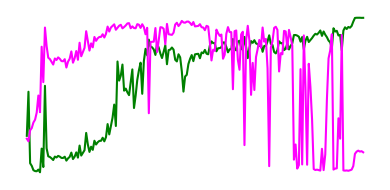

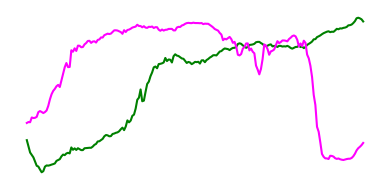

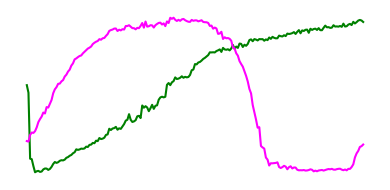

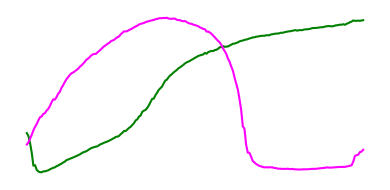

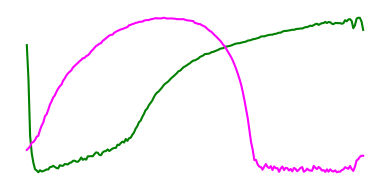

In [20]:
mod = "bf"
idx = 25


for head in good_heads:
    fig, ax1 = plt.subplots(1, 1, figsize=(4, 2), sharey=True)

    ax1.plot(data[mod][head][idx][:, 0], label=f"{head}", color="green", alpha=1)
    ax1.plot(data[mod][head][idx][:, 1], label=f"{head}", color="magenta", alpha=1)
    #ax1.grid('off')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.axis('off')
    plt.savefig(f'{head}_track.png', bbox_inches='tight', dpi=300)
    plt.tight_layout()
    plt.show()

# checkpoints

In [25]:
rows.__len__()

12

In [56]:

columns = ['L_1', 'L_{1, FUCCI_1}', 'L_{1, FUCCI_2}', 'R^2', 'DTW', ]
super_columns = {'bf':"Brightfield", 'h2b': "Histone H2B"}

good_heads = ["mlp", "cnn", "lstm", "xtransformer-causal", "mamba", "xtransformer"]
models = {key:val for key, val in zip(good_heads, ['Single Frame', 'Causal CNN', 'LSTM', 'Causal Transformer', 'Mamba', 'Transformer'])}

#good_heads = ["mlp", "cnn", "mamba", "xtransformer"]
#models = {key:val for key, val in zip(good_heads, ['Single Frame', 'Causal CNN', 'Mamba', 'Transformer'])}

In [58]:
threshold_green, threshold_red = 0.05, 0.05
x_crossings_gt, idx_crossing_gt = find_crossing_points(taus, gt_tracks, tr_green=threshold_green, tr_red=threshold_red, smooth_window=None)

rows = []
for mod in ['bf', 'h2b']:
    for head in good_heads:
        _, idx = find_crossing_points(taus, data[mod][head], tr_green=threshold_green, tr_red=threshold_red, smooth_window=None)
        rows.append([np.nanmean(np.abs(idx - idx_crossing_gt), axis=0), np.nanstd(np.abs(idx - idx_crossing_gt), axis=0)])

rows_mean = [r[0].tolist() for r in rows]
rows_std = [r[1].tolist() for r in rows]
data_ = pd.concat([pd.DataFrame(rows_mean[:len(rows_mean)//2]), pd.DataFrame(rows_mean[len(rows_mean)//2:])], axis=1)
data_.columns = pd.MultiIndex.from_product([list(super_columns.values()), ['$\Delta t_{G1/S}$', '$\Delta t_{S/G2}$']])
data_.index = list(models.values())
data_ = data_.map(lambda x: x*5)

latex_df = data_.copy()
import itertools
std_values = pd.concat([pd.DataFrame(rows_std[:len(rows_mean)//2]), pd.DataFrame(rows_std[len(rows_mean)//2:])], axis=1)
std_values.columns = pd.MultiIndex.from_product([list(super_columns.values()), ['$\Delta t_{G1/S}$', '$\Delta t_{S/G2}$']])
std_values.index =   list(models.values())
std_values = std_values.map(lambda x: x*5)

for col in itertools.product(list(super_columns.values()), ['$\Delta t_{G1/S}$', '$\Delta t_{S/G2}$']):
    min_value = data_[col].min()
    std_val = std_values[col]
    latex_df[col] = data_[col].apply(lambda x: f"\\textbf{{{x:.1f}}}" if x == min_value else f"{x:.1f}")
    latex_df[col] += std_val.apply(lambda s: f" \\textbf{{± {s:.1f}}}" if s == std_val.min() else f" ± {s:.1f}")

display(latex_df)
with open("checkpoints_table_fullhead_plusminus.tex", "w") as f:
    f.write(latex_df.to_latex(index=True, escape=False))

Brightfield  \
                                $\Delta t_{G1/S}$   
Single Frame                        191.3 ± 119.2   
Causal CNN                          146.8 ± 105.3   
LSTM                                 102.0 ± 85.8   
Causal Transformer                   105.8 ± 90.9   
Mamba                                111.4 ± 90.5   
Transformer         \textbf{60.1} \textbf{± 64.2}   

                                                   \
                                $\Delta t_{S/G2}$   
Single Frame                         117.9 ± 83.8   
Causal CNN                           113.3 ± 79.3   
LSTM                                  98.1 ± 79.1   
Causal Transformer                   106.9 ± 81.2   
Mamba                                102.4 ± 81.1   
Transformer         \textbf{57.2} \textbf{± 57.0}   

                                      Histone H2B  \
                                $\Delta t_{G1/S}$   
Single Frame                        173.5 ± 119.9   
Causal CNN                          158.0 ± 113.7   
LSTM                                 100.1 ± 91.7   
Causal Transformer                   109.2 ± 93.2   
Mamba                                107.3 ± 94.8   
Transformer         \textbf{39.2} \textbf{± 33.5}   

                                                   
                                $\Delta t_{S/G2}$  
Single Frame                        140.3 ± 110.2  
Causal CNN                          127.6 ± 109.1  
LSTM                                  63.7 ± 50.7  
Causal Transformer                    62.5 ± 52.1  
Mamba                                 59.5 ± 48.8  
Transformer         \textbf{47.5} \textbf{± 46.1}

In [20]:

threshold_green, threshold_red = 0.05, 0.05
x_crossings_gt, idx_crossing_gt = find_crossing_points(taus, gt_tracks, tr_green=threshold_green,tr_red=threshold_red, smooth_window=None)

rows = []
for mod in ['bf', 'h2b']:
    for head in good_heads:
        _, idx = find_crossing_points(taus, data[mod][head], tr_green=threshold_green,tr_red=threshold_red, smooth_window=None)
        rows.append(np.nanmean(np.abs(idx - idx_crossing_gt), axis=0).tolist())

data_ = pd.concat([pd.DataFrame(rows[:len(rows)//2]), pd.DataFrame(rows[len(rows)//2:])], axis=1)
data_.columns = pd.MultiIndex.from_product([list(super_columns.values()), ['$\delta t_{G1/S}$', '$\delta t_{S/G2}$']])
data_.index =list( models.values() )
data_ = data_.map(lambda x: x*5)

latex_df = data_.copy()
import itertools
for col in itertools.product(list(super_columns.values()), ['$\delta t_{G1/S}$', '$\delta t_{S/G2}$']):
    min_value = data_[col].min()
    latex_df[col] = data_[col].apply(
        lambda x: f"\\textbf{{{x:.1f}}}" if x == min_value else f"{x:.1f}"
    )
display(latex_df)
latex_df.to_latex(index=True, escape=False)
# Save the LaTeX table to a file
with open("table2.tex", "w") as f:
    f.write(latex_df.to_latex(index=True, escape=False))

Brightfield                         Histone H2B  \
                   $\delta t_{G1/S}$ $\delta t_{S/G2}$ $\delta t_{G1/S}$   
Single Frame                   191.3             117.9             173.5   
Causal CNN                     146.8             113.3             158.0   
LSTM                           102.0              98.1             100.1   
Causal Transformer             105.8             106.9             109.2   
Mamba                          111.4             102.4             107.3   
Transformer            \textbf{60.1}     \textbf{57.2}     \textbf{39.2}   

                                      
                   $\delta t_{S/G2}$  
Single Frame                   140.3  
Causal CNN                     127.6  
LSTM                            63.7  
Causal Transformer              62.5  
Mamba                           59.5  
Transformer            \textbf{47.5}

In [62]:

threshold_green, threshold_red = 0.03, 0.005
idx_crossing_gt, idx_crossing_gt = find_crossing_points(taus, gt_tracks, tr_green=threshold_green,tr_red=threshold_red, smooth_window=None)

rows = []
for mod in ['bf', 'h2b']:
    for head in good_heads:
        _, idx = find_crossing_points(taus, data[mod][head], tr_green=threshold_green,tr_red=threshold_red, smooth_window=None)
        rows.append(np.nanmean(np.abs(idx - idx_crossing_gt), axis=0).tolist())
        plt.figure(figsize=(10, 5))
        for i in range(1):
            plt.suptitle("GT")
            plt.subplot(1, 2, 1)
            plt.title(f"log signal")
            plt.plot(gt_tracks[i][:, 0], color="green")
            plt.plot(gt_tracks[i][:, 1], color="magenta")
            plt.axvline(idx_crossing_gt[i, 0], color="black", linestyle="--")
            #plt.axvline(idx_crossing_gt[i, 1], color="black", linestyle="--")
            plt.close()

            plt.figure(figsize=(10, 5))
            plt.title(f"Prediction {head} {mod}")
            plt.plot(data[mod][head][i][:, 0], color="green")
            plt.plot(data[mod][head][i][:, 1], color="magenta")
            plt.axvline(idx[i, 0], color="black", linestyle="--")
            #plt.axvline(idx[i, 1], color="black", linestyle="--")
            plt.close()


In [63]:

columns = ['L_1', 'L_{1, FUCCI_1}', 'L_{1, FUCCI_2}', 'R^2', 'DTW', ]
super_columns = {'bf':"Brightfield", 'h2b': "Histone H2B"}
models = {key:val for key, val in zip(good_heads, ['Single Frame', 'Causal CNN', 'Mamba', 'Transformer'])}

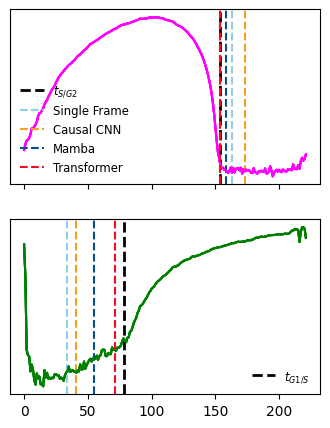

In [90]:

threshold_green, threshold_red = 0.03, 0.005
idx_crossing_gt, idx_crossing_gt = find_crossing_points(taus, gt_tracks, tr_green=threshold_green,tr_red=threshold_red, smooth_window=None)

rows = []
for mod in ['bf']:
    i = 26
    fig, ax = plt.subplots(2, 1, figsize=(4, 5), sharex=True, sharey=True)
    ax[0].axvline(idx_crossing_gt[i, 1], color="black", linestyle="--", alpha=1, label="$t_{S/G2}$", lw=2)
    ax[1].axvline(idx_crossing_gt[i, 0], color="black", linestyle="--", alpha=1, label="$t_{G1/S}$", lw=2)
    ax[1].legend(frameon=False, fontsize="small", loc='lower right')
    ax[0].set_yticks([])
    ax[1].set_yticks([])
    for color, head in zip( ['#95cee1',"#f19e21", "#0a4d8b",    "#f60b20",], good_heads):
        _, idx = find_crossing_points(taus, data[mod][head], tr_green=threshold_green,tr_red=threshold_red, smooth_window=None)
        rows.append(np.nanmean(np.abs(idx - idx_crossing_gt), axis=0).tolist())
        ax[0].plot(gt_tracks[i][:, 1], color="magenta")
        ax[0].axvline(idx[i, 1], color=color, linestyle="--", label = models[head])
        ax[1].plot(gt_tracks[i][:, 0], color="green")
        ax[1].axvline(idx[i, 0], color=color, linestyle="--", label = models[head])
    ax[0].legend(frameon=False, fontsize="small", loc='lower left')
    plt.show()

In [35]:
pd.DataFrame(rows)

,0,1
0,38.262570,23.575419
1,29.368715,22.650838
2,22.270950,20.486034
3,12.025140,11.446927
4,34.692737,28.057143
5,31.600559,25.525568
6,21.455307,11.893855
7,7.846369,9.509804


In [ ]:

threshold_green, threshold_red = 0.1, 0.05
x_crossings_gt, idx_crossing_gt = find_crossing_points(taus, gt_tracks, tr_green=threshold_green,tr_red=threshold_red, smooth_window=10)

rows = []
for mod in ['bf', 'h2b']:
    for head in good_heads:
        _, idx = find_crossing_points(taus, data[mod][head], tr_green=threshold_green,tr_red=threshold_red, smooth_window=10)
        rows.append((idx - idx_crossing_gt).mean(axis=0).tolist())



plt.figure(figsize=(10, 5))
plt.suptitle("GT")

idx = np.random.randint(0, n_tracks)

plt.subplot(1, 2, 1)
plt.title(f"log signal")
plt.plot(taus[idx], gt_tracks[idx][:, 0], color="green")
plt.plot(taus[idx], gt_tracks[idx][:, 1], color="red")

fuc = inverse_log_min_max(gt_tracks[idx], eps=0.01, log_base=np.e)

plt.subplot(1, 2, 2)
plt.title(f"linear signal")
plt.plot(taus[idx], fuc[:, 0], color="green")
plt.plot(taus[idx], fuc[:, 1], color="red")


plt.axvline(x_crossings_gt[idx, 0], color="black", linestyle="--")
plt.axvline(x_crossings_gt[idx, 1], color="black", linestyle="--")
plt.show()


plt.figure(figsize=(10, 5))
plt.suptitle(f"prediction {head} {modality}")

plt.subplot(1, 2, 1)
plt.title(f"log signal")
plt.plot(taus[idx], tracks[idx][:, 0], color="green")
plt.plot(taus[idx], tracks[idx][:, 1], color="red")

fuc = inverse_log_min_max(tracks[idx], eps=0.01, log_base=np.e)

plt.subplot(1, 2, 2)
plt.title(f"linear signal")
plt.plot(taus[idx], fuc[:, 0], color="green")
plt.plot(taus[idx], fuc[:, 1], color="red")


plt.axvline(x_crossings[idx, 0], color="black", linestyle="--")
plt.axvline(x_crossings[idx, 1], color="black", linestyle="--")

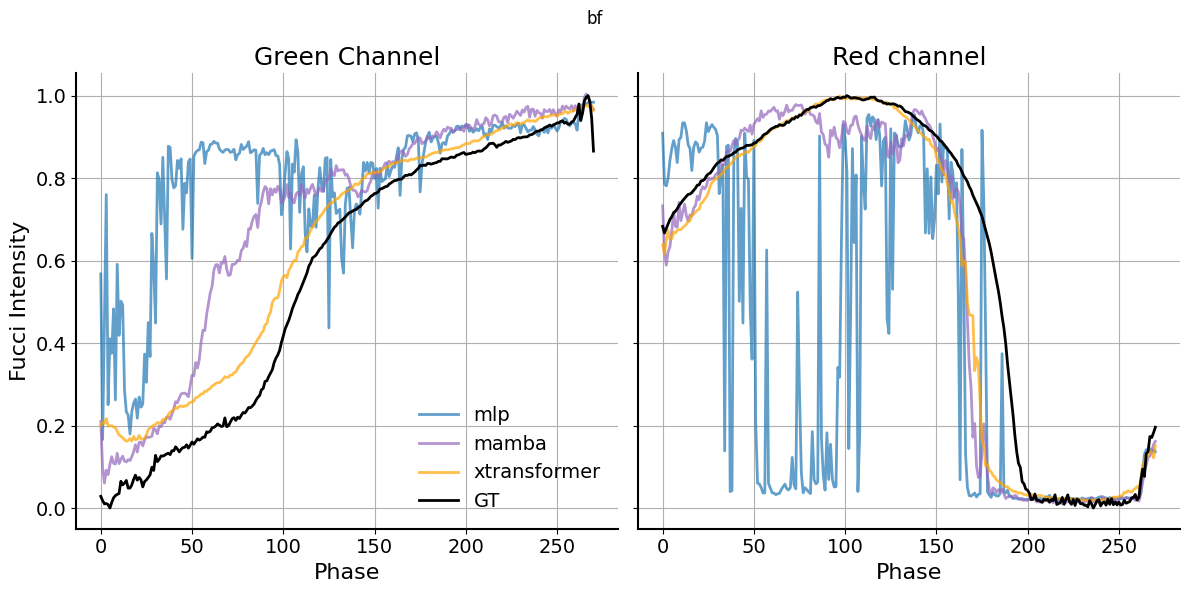

In [12]:
# choose modality here
mod = "bf"
# choose track here
idx = 119
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.suptitle(mod)

# Left subplot for errors_g_averaged
ax1.set_title("Green Channel")
ax1.set_xlabel("Phase")
ax1.set_ylabel("Fucci Intensity")


for head in good_heads:
    ax1.plot(data[mod][head][idx][:, 0], label=f"{head}", color=head_colors[head], alpha=0.7)

ax1.plot(gt_tracks[idx][:, 0], label="GT", color="black")
ax1.legend()
ax1.grid()

# Right subplot for errors_r_averaged
ax2.set_title("Red channel")
ax2.set_xlabel("Phase")

for head in good_heads:
    ax2.plot(data[mod][head][idx][:, 1], label=f"{head}", color=head_colors[head], alpha=0.7)

ax2.plot(gt_tracks[idx][:, 1], label="GT", color="black")

# ax2.legend()
ax2.grid()

# Ensure tight layout and consistent y-axis scaling
plt.tight_layout()

# save the figure
# plt.savefig(f"../plots/av_error/profile_{mod}.pdf")
plt.show()